In [1]:
from PIL import Image, ImageDraw
import pandas as pd
import json
import os
import ast
from sklearn.model_selection import train_test_split
import wandb
from pytorch_lightning.loggers import WandbLogger
import torchvision
from torchvision import transforms

from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#need a train / test/ val 

#Threshold accuracy for bb to be 0.95
#do 500x500 for images
#should we take 1000x1000 images and split them into 4 images? (shifting around the bounding boxes accordingly) 

#At inference, for a 1000x1000 image of id 'ABC', split into 4 iamges of 500x500 and have them be ABC_n , {n E 1-4 },then for the labelling 
#in the csv we will have to retransform where those bounding boxes actually should appear on the original 1000x1000 image and place metadata into csv submission



In [2]:
import os
print("Current Working Directory:", os.getcwd())



Current Working Directory: C:\Users\iansa\Zindi


In [3]:
COCO_DATASET = "dataset_coco_format.json"
DATA_FOLDER = 'Data'
TEST_CSV = "Test.csv"
IMAGE_FOLDER = "Images/Images"
TRAIN_CSV = "Train.csv"
labels_dict = {1: "Other", 2: "Tin", 3: "Thatch"}


In [4]:
# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)
train_df.columns

Index(['image_id', 'bbox', 'category_id', 'id'], dtype='object')

In [5]:
### Look at the image sizes for all

# Define the directory containing the images
directory_path = r'C:\Users\iansa\Zindi\Images\Images'

# Set to hold the unique dimensions
unique_dimensions = set()

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".tif"):  # Check for .tif files
        # Construct full file path
        file_path = os.path.join(directory_path, filename)
        # Open the image and get its size
        with Image.open(file_path) as img:
            dimensions = img.size  # Get dimensions, which is a tuple (width, height)
            unique_dimensions.add(dimensions)  # Add dimensions to the set

# Print out the unique dimensions
for dimensions in unique_dimensions:
    print(f"Unique dimensions: {dimensions}")
    
## BOTH TEST AND TRAIN HAVE THESE 2 SIZES ##

Unique dimensions: (500, 500)
Unique dimensions: (1000, 1000)


C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


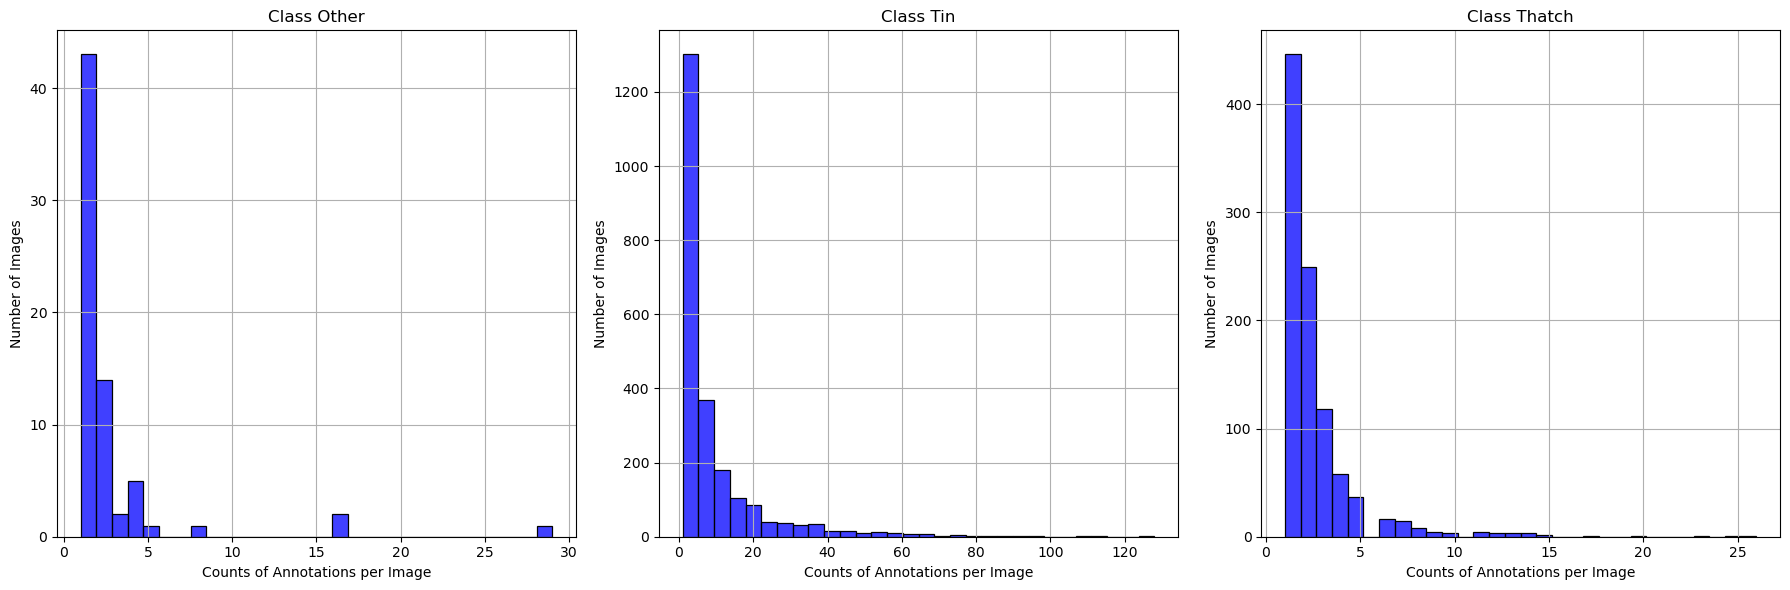

   Category ID  Count Category Name  Percentage of Total
0          1.0    171         Other             0.717011
1          2.0  21330           Tin            89.437712
2          3.0   2348        Thatch             9.845277


In [6]:
# Take a look at object counts per image

# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)

# Assume 'class_id' is a column in train_df specifying the annotation class
# Aggregate counts of annotations per image per class
annotation_counts = train_df.groupby(['image_id', 'category_id']).size().reset_index(name='counts')

# Plotting
plt.figure(figsize=(18, 6))  # Set the overall figure size

# Define the unique classes - assuming they are 1, 2, 3 as per your 'labels_dict'
classes = [1, 2, 3]
for i, category_id in enumerate(classes, 1):
    plt.subplot(1, 3, i)  # Create a subplot for each class
    class_data = annotation_counts[annotation_counts['category_id'] == category_id]
    sns.histplot(class_data['counts'], bins=30, kde=False, color='blue')
    plt.title(f'Class {labels_dict[category_id]}')
    plt.xlabel('Counts of Annotations per Image')
    plt.ylabel('Number of Images')
    plt.grid(True)  # Optional: Add grid for better readability

plt.tight_layout()
plt.show()

import pandas as pd

# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)

# Assume 'category_id' is now the column name specifying the annotation category
# Aggregate counts of annotations per category
category_annotation_counts = train_df['category_id'].value_counts().sort_index()

# Convert to DataFrame for better presentation
category_annotation_counts_df = category_annotation_counts.reset_index()
category_annotation_counts_df.columns = ['Category ID', 'Count']

# Add category names based on your existing labels dictionary or similar mapping
labels_dict = {1: "Other", 2: "Tin", 3: "Thatch"}  # Update or modify as per your data
category_annotation_counts_df['Category Name'] = category_annotation_counts_df['Category ID'].map(labels_dict)

# Calculate total annotations to find percentages
total_annotations = category_annotation_counts_df['Count'].sum()
category_annotation_counts_df['Percentage of Total'] = (category_annotation_counts_df['Count'] / total_annotations) * 100

# Print the table with all the required information
print(category_annotation_counts_df)




In [7]:
# Creates COCO format .json from csv / images

#Functions for creating COCO format json
train = pd.read_csv(TRAIN_CSV, header=0)
train.dropna(inplace=True)

train['bbox'] = train['bbox'].apply(ast.literal_eval)

# Initialize the COCO format dictionary
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "Other"},
        {"id": 2, "name": "Tin"},
        {"id": 3, "name": "Thatch"}
    ]
}
index_dict = {}
i = 0
unique_image_ids = train['image_id'].unique()
for image_id in unique_image_ids:
    index_dict[image_id] = i
    i += 1


# Helper function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


if __name__ == '__main__':
    # Populate images section
    unique_image_ids = train['image_id'].unique()
    for image_id in unique_image_ids:
        file_name = f"{image_id}.tif"  # Adjust the extension if needed
        image_path = os.path.join(IMAGE_FOLDER, file_name)
        width, height = get_image_dimensions(image_path)
        coco_format["images"].append({
            "id": index_dict[image_id],
            "file_name": file_name,
            "width": width,
            "height": height
        })

    # Annotations
    for index, row in train.iterrows():
        annotation = {
            "id": index,
            "image_id": index_dict[row["image_id"]],
            "category_id": int(row["category_id"]),
            "bbox": row["bbox"],
            "area": row["bbox"][2] * row["bbox"][3],  # width * height
            "iscrowd": 0,
            "segmentation": []  # Empty if not using segmentation
        }
        coco_format["annotations"].append(annotation)

    # Save to JSON
    with open(r'Data\dataset_coco_format.json', 'w') as f:
        json.dump(coco_format, f, indent=4)

In [319]:
import json

def filter_annotations_for_class(input_file, output_file, target_class_id):
    """
    Filter the annotations to include only those that match a specific class,
    and save to a new JSON file for binary classification training.

    Parameters:
    - input_file: Path to the original COCO-format JSON file.
    - output_file: Path where the filtered JSON file will be saved.
    - target_class_id: The ID of the class to filter for binary classification.
    """
    # Load the original COCO dataset
    with open(input_file, 'r') as file:
        data = json.load(file)

    # Filter images and annotations
    filtered_images = []
    filtered_annotations = []
    image_ids = set()

    # Include only annotations that match the target class, and collect their image IDs
    for annotation in data['annotations']:
        if annotation['category_id'] == target_class_id:
            filtered_annotations.append(annotation)
            image_ids.add(annotation['image_id'])
            annotation['category_id'] = 1  # Set class to 1 (object)

    # Include images that are used in the filtered annotations
    for image in data['images']:
        if image['id'] in image_ids:
            filtered_images.append(image)

    # Prepare the new dataset structure
    new_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': [{'id': 1, 'name': 'Tin'}]  # Binary class
    }

    # Save the filtered data to a new JSON file
    with open(output_file, 'w') as file:
        json.dump(new_data, file, indent=4)

# Example usage
input_annotation_file = r"C:\Users\iansa\Zindi\Data\dataset_coco_format.json"
output_annotation_file = r'Data\binary_annotations2.json'
class_id_of_interest = 2  # Change this to your target class ID
filter_annotations_for_class(input_annotation_file, output_annotation_file, class_id_of_interest)


In [8]:
# Weights and Biases - this will help us track and view our training
PROJECT_NAME = 'detr_hous_count'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Getting_started_detr_hf.ipynb'

wandb.login()
wandb.init(project=PROJECT_NAME)

wandb_logger = WandbLogger(name="MyModelRun", project=PROJECT_NAME)

wandb: Currently logged in as: iansamhowe (zinditeam). Use `wandb login --relogin` to force relogin


In [9]:
# Load the COCO dataset JSON
#Train / Test split the annotation data
annotation_file = 'dataset_coco_format.json'
with open(os.path.join(DATA_FOLDER, annotation_file), 'r') as f:
    coco = json.load(f)

# Extract annotations and images
annotations = coco['annotations']
images = coco['images']

# Split images directly
images_train, images_val = train_test_split(images, test_size=0.2)

# Get the IDs of the split images
images_train_ids = {img['id'] for img in images_train}
images_val_ids = {img['id'] for img in images_val}

# Filter annotations to only include those present in train/val images
annotations_train = [ann for ann in annotations if ann['image_id'] in images_train_ids]
annotations_val = [ann for ann in annotations if ann['image_id'] in images_val_ids]

# Create new JSON objects for train and validation sets
coco_train = {'images': images_train, 'annotations': annotations_train, 'categories': coco['categories']}
coco_val = {'images': images_val, 'annotations': annotations_val, 'categories': coco['categories']}

# Save new JSON files for train and validation datasets
with open(os.path.join(DATA_FOLDER, 'train.json'), 'w') as f:
    json.dump(coco_train, f)

with open(os.path.join(DATA_FOLDER, 'val.json'), 'w') as f:
    json.dump(coco_val, f)

In [31]:
# import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor, transforms=None):
        """
        Initialize the CocoDetection class which is a subclass of torchvision.datasets.CocoDetection.
        This subclass is designed to integrate a custom preprocessing step for each data retrieval.

        Parameters:
        - img_folder (str): The directory path where the image files are stored.
        - ann_file (str): The path to the COCO annotation file in JSON format.
        - processor (callable): A function or callable object that processes images and their annotations.
        - transforms (callable, optional): A function or callable object that applies data augmentations.
        """
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor
        self.transforms =A.Compose([
            A.Rotate(limit=40, p=0.9),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.3),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))


    def __getitem__(self, idx):
        # Retrieve image and its annotations in COCO format using the superclass method.
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # Apply the transformations
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=[t['bbox'] for t in target['annotations']], labels=[t['category_id'] for t in target['annotations']])
            img = transformed['image']
            target['annotations'] = [{'bbox': bbox, 'category_id': label} for bbox, label in zip(transformed['bboxes'], transformed['labels'])]
    
        # Include the image ID in the target for traceability and further processing needs
        image_id = self.ids[idx]  # Retrieve the image ID from the dataset's index list.
        target = {'image_id': image_id, 'annotations': target['annotations']}  # Reformat the target dictionary to include the image ID.
        
        # Apply the processor to the image and annotations to transform them into the required format for the model.
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        
        # Extract the processed image tensor and squeeze out any unnecessary batch dimensions.
        pixel_values = encoding["pixel_values"].squeeze()
        
        # Similarly, get the first item from the labels tensor which contains the processed annotations.
        target = encoding["labels"][0]
    
        # Return the processed image tensor and target annotations.
        return pixel_values, target




# class CocoDetection(torchvision.datasets.CocoDetection):
#     def __init__(self, img_folder, ann_file, processor):
#         super().__init__(img_folder, ann_file)
#         self.processor = processor
#         self.transforms = A.Compose([
#             A.Rotate(limit=360, p=1.0),  # Rotate the image up to 360 degrees with probability 1
#             ToTensorV2()
#         ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))
#         """
#         Initialize the CocoDetection class which is a subclass of torchvision.datasets.CocoDetection.
#         This subclass is designed to integrate a custom preprocessing step for each data retrieval.

#         Parameters:
#         - img_folder (str): The directory path where the image files are stored.
#         - ann_file (str): The path to the COCO annotation file in JSON format.
#         - processor (callable): A function or callable object that processes images and their annotations.
#                                 It is expected to handle tasks like data augmentation, resizing, and normalization.
#         """
#         # Initialize the superclass with the provided image folder and annotation file.
#         # super(CocoDetection, self).__init__(img_folder, ann_file)
        
#         # Store the processor callable which will be used to preprocess images and annotations.
#         # self.processor = processor
        
#     """  __getitem__ is implicitly used by the DataLoader objects
#     DataLoader Interaction: When you create a DataLoader instance for your dataset, PyTorch's DataLoader internally calls the __getitem__ method 
#     to retrieve items. 
#     This is done batch-wise; the DataLoader fetches several data items by invoking __getitem__ 
#     multiple times to form a batch."""
    
#     def __getitem__(self, idx):
#         """
#         Retrieve an image and its annotations by index, process them using the specified processor,
#         and return the processed image and target suitable for model training.

#         Parameters:
#         - idx (int): The index of the data item to fetch.

#         Returns:
#         - pixel_values (tensor): The processed image tensor ready for input to a model.
#         - target (dict): The processed annotations including labels and other necessary information for training.
#         """
#         # Read in the PIL image and its target in COCO format using the superclass method.
#         # This is the standard retrieval process which fetches the raw image and its annotations.
#         img, target = super(CocoDetection, self).__getitem__(idx)

#         # Here you can optionally add more data augmentation processes to the image and annotations before further processing.
#         transform = transforms.Compose([
#         # transforms.Resize((800, 800)),  # Resize the image to a fixed size
#         transforms.ToTensor()  # Scales pixels between 0 and 1
#         ])
        
#         # Preprocess the image and its annotations. This includes:
#         # - Converting the annotations to the format required by the model (e.g., DETR).
#         # - Resizing and normalizing the image and annotations.
#         # - Using the 'processor' callable to transform the data into tensors and apply any other necessary preprocessing.
#         image_id = self.ids[idx]  # Retrieve the image ID from the dataset's index list.
#         target = {'image_id': image_id, 'annotations': target}  # Reformat the target dictionary to include the image ID.
        
#         # Apply the processor to the image and annotations to transform them into the required format for the model.
#         encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        
#         # Extract the processed image tensor and squeeze out any unnecessary batch dimensions.
#         pixel_values = encoding["pixel_values"].squeeze()
        
#         # Similarly, get the first item from the labels tensor which contains the processed annotations.
#         target = encoding["labels"][0]

#         # Return the processed image tensor and target annotations.
#         return pixel_values, target


In [32]:
# Import the necessary module for the DETR model's image processor.
import torchvision

#Converts Raw COCO format into DETR
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")


train_dataset = CocoDetection(img_folder=IMAGE_FOLDER, ann_file=r'Data/train.json', processor=processor)
val_dataset = CocoDetection(img_folder=IMAGE_FOLDER, ann_file=r'Data/val.json', processor=processor)


print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 1972
Number of validation examples: 493


In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image
import random

def show_image_with_boxes(img, boxes, ax, title):
    ax.imshow(img)
    ax.set_title(title)
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

def visualize_augmentation(dataset, idx):
    img, target = dataset[idx]
    # Convert tensor image back to PIL for display
    img_pil = to_pil_image(img)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    show_image_with_boxes(img_pil, target['boxes'], ax, 'Augmented Image with Bounding Boxes')
    plt.show()

# Randomly select an index
random_idx = random.randint(0, len(train_dataset) - 1)
visualize_augmentation(train_dataset, random_idx)


KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

Image n°1856


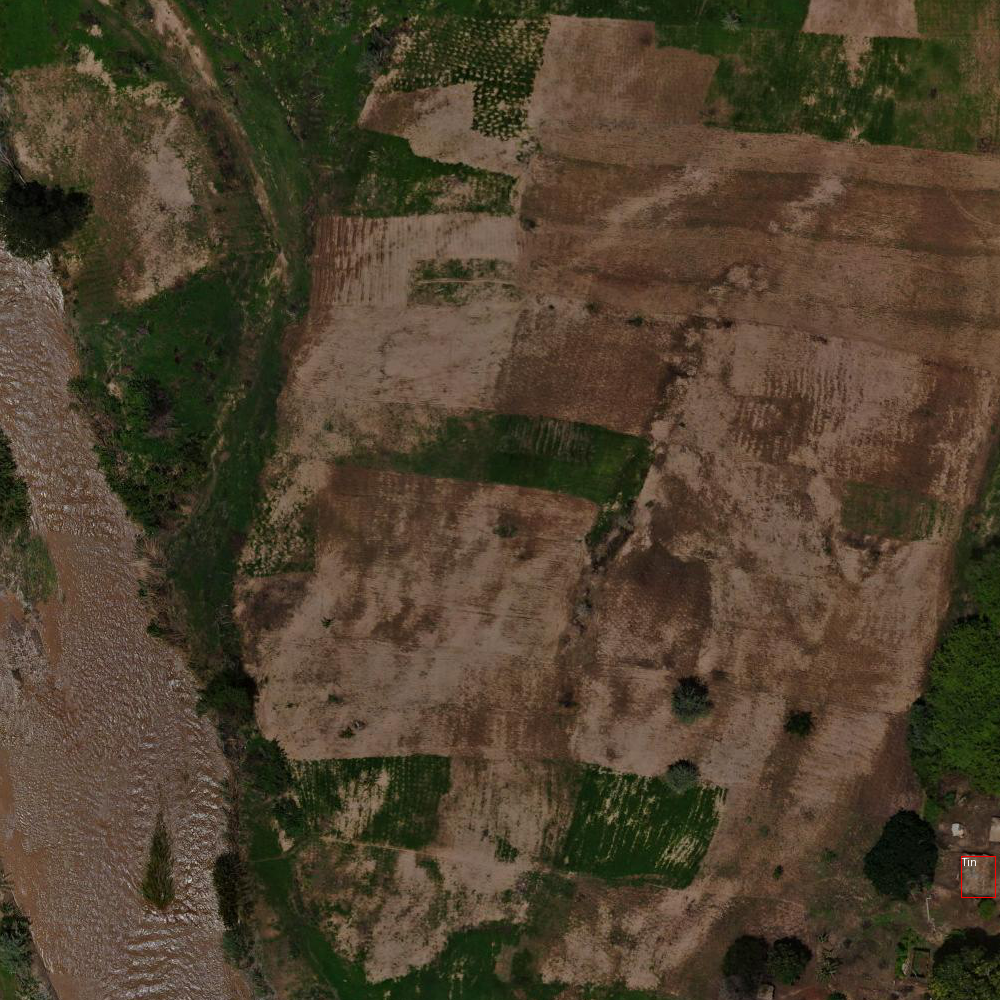

In [12]:
# # based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(IMAGE_FOLDER, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

#1365 thatch (should be tin...)

# 2333 - discard
#160 - line messup
#74 - small scale
#id_1qexi5hkuk5p not OTHER 

In [329]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=40, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=40)

In [330]:
class Detr(pl.LightningModule):
    def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101",
                                                            revision="no_timm",
                                                            num_labels=2,
                                                            ignore_mismatched_sizes=True)
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        # self.class_weights = torch.tensor([0.100, 0.01, 10]) 
    

    
    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                      weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [331]:
model = Detr()

trainer = Trainer(max_epochs=10, accelerator='gpu',logger=wandb_logger)
trainer.fit(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-101 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CU

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [332]:


# Define the path for saving the entire model
model_path = 'C:\\Users\\iansa\\Zindi\\Model\\tin_2_model.pth'  # Use double backslashes on Windows

# Save the entire model
torch.save(model, model_path)


In [296]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
print(device)

cuda


In [297]:
test_df = pd.read_csv(os.path.join('Data',TEST_CSV))

In [298]:

test_list = test_df['image_id'].to_list()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [337]:
labels_dict = {0: "Background", 1: "Tin"}

def plot_results(img_name):
    image = Image.open(os.path.join(IMAGE_FOLDER, f'{img_name}.tif'))
   
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    print("Outputs:", outputs.keys())    
    postprocessed_outputs  =  processor.post_process_object_detection(outputs,
                                                        target_sizes=[(height, width)],
                                                        threshold=0.7)
    results = postprocessed_outputs[0]

    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for score, label, (xmin, ymin, xmax, ymax)  in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, linewidth=3))
        text = f'{labels_dict[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [358]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Assuming 'labels_dict' and 'processor' are defined globally
# Assuming 'IMAGE_FOLDER' and 'device' are defined globally

def plot_results(img_name):
    image_path = os.path.join(IMAGE_FOLDER, f'{img_name}.tif')
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

    # Print out the image size
    print(f"Image size: {image.size} (Width x Height), Filename: {img_name}.tif")

    # Preprocess the image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    postprocessed_outputs = processor.post_process_object_detection(
        outputs,
        target_sizes=[image.size],  # Directly use the actual image size
        threshold=0.90
    )
    results = postprocessed_outputs[0]

    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    ax = plt.gca()

    for score, label, (xmin, ymin, xmax, ymax) in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, linewidth=3))
        text = f'{labels_dict.get(label, "Unknown")}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

In [359]:
model = torch.load(r"C:\Users\iansa\Zindi\Model\tin_2_model.pth")

# You might need to modify paths and ensure the model class correctly matches how you're using DETR.



# Load your trained model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Image size: (1000, 1000) (Width x Height), Filename: id_xagrs2wbmc2i.tif


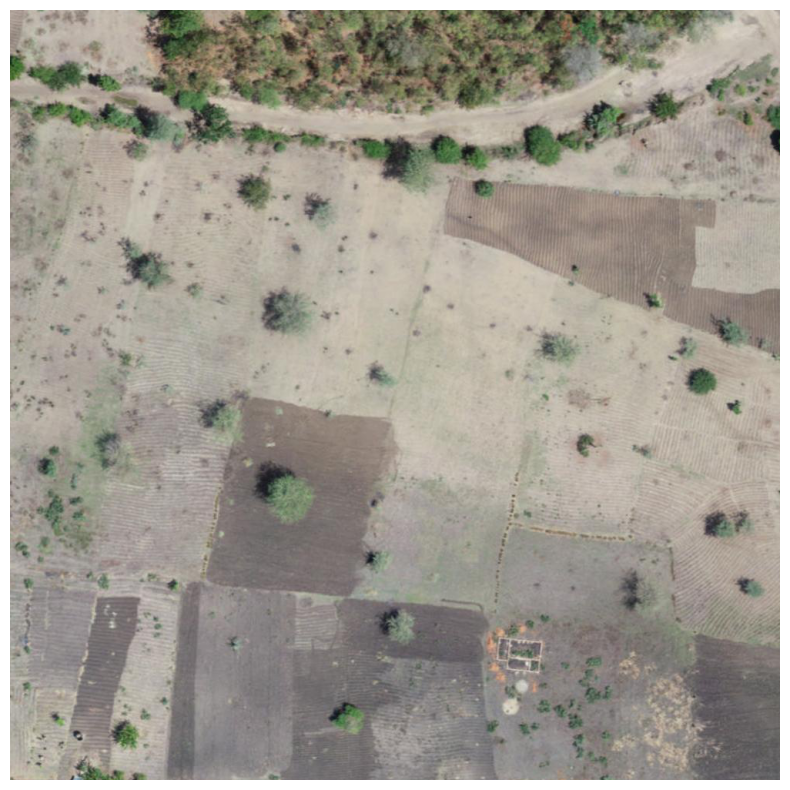

Image size: (1000, 1000) (Width x Height), Filename: id_eddjh7nm72iq.tif


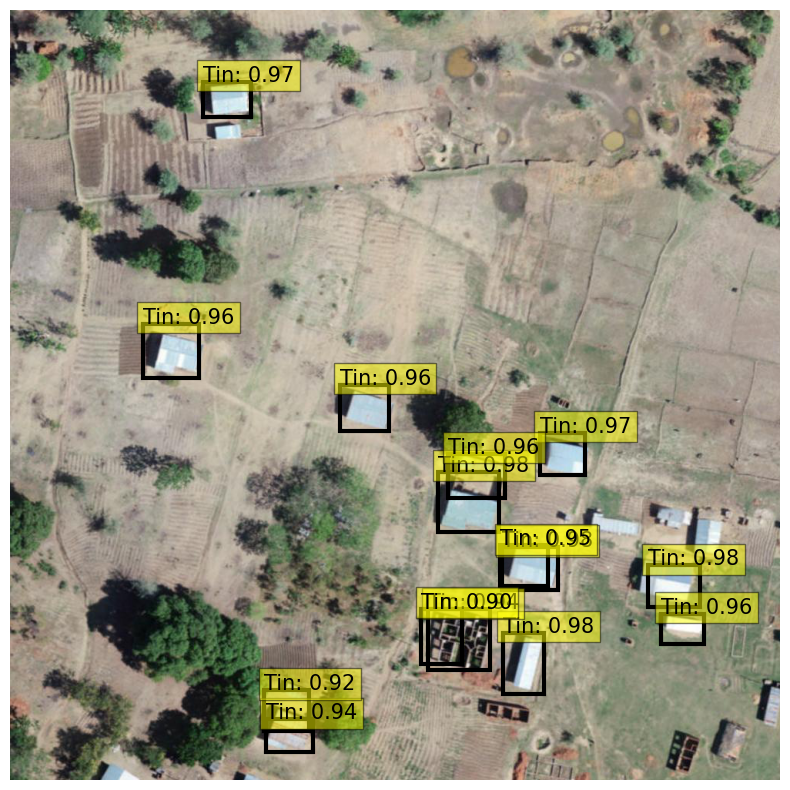

In [372]:
import random
model = model.to(device)
random_img = random.choice(test_list)
plot_results(random_img)
# plot_results('id_yqj86j1t7wtp')#id_yqj86j1t7wtp.tif
plot_results('id_eddjh7nm72iq')#id_6cgnpjjqyg4b